# Model developement to predict the rating of a movie: Part-I
***
After pre-processing and feature engineering, models were developed. As it is to predict the rating, it is a regression problem with a limitation that the target variable 0-10 instead of -inf to +inf. Different aspects of model development and optimization were adopted to obtain a most reliable model. The model development was separated into different parts taking into account the run-time. <br><br>In this Part models were developed as follows:

1. **Without PCA**

2. **ML models:**
    * **Simple Linear Regression, Lasso Regression, Ridge    Regression**
    * **Random Forest Regressor**
    * **Gradient Boosting Regressor**

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression

In [2]:
# Import the datasets
IMDB_only = pd.read_csv('pre-processed_dataset/IMDB_only.csv', index_col = 0)
IMDB_Kaggle_common = pd.read_csv('pre-processed_dataset/IMDB_Kaggle_common.csv', index_col = 0)

In [3]:
IMDB_only.shape

(69458, 1089)

In [4]:
IMDB_Kaggle_common.shape

(2585, 1089)

In [5]:
IMDB_only.columns[:10]

Index(['duration_min', 'avg_vote', 'votes', 'reviews_from_users', 'Comedy',
       'Family', 'Sci-Fi', 'Adventure', 'Crime', 'Reality-TV'],
      dtype='object')

In [6]:
# Split the IMDB_only dataset into X and y for model development 
y = IMDB_only['avg_vote']
X = IMDB_only.drop(columns = 'avg_vote')

In [7]:
print(X.shape)
print(y.shape)

(69458, 1088)
(69458,)


## train test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [9]:
print(X_train.shape)
print(X_test.shape)

(48620, 1088)
(20838, 1088)


### Ordinary Linear Regression

In [10]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_train_predict = lr.predict(X_train)
y_test_predict = lr.predict(X_test)

In [11]:
lr.intercept_

5.930399089262735

In [12]:
sorted(lr.coef_)[:10]

[-1060426574239.8799,
 -558557858610.9672,
 -532960910080.86115,
 -416180880899.1734,
 -407295445212.3002,
 -360066668900.0519,
 -338545712619.7192,
 -222797988918.94394,
 -216654642395.95847,
 -197912596632.8925]

In [13]:
r2_score(y_train, y_train_predict), r2_score(y_test, y_test_predict)

(0.43115359380742047, -9.53224537183682e+19)

In [14]:
from sklearn.metrics import mean_squared_error
print("The mean squared error:", mean_squared_error(y_test, y_test_predict))

from sklearn.metrics import mean_squared_error
print("The root mean squared error:", mean_squared_error(y_test, y_test_predict, squared = False))

from sklearn.metrics import mean_absolute_error
print("The mean absolute error:", mean_absolute_error(y_test, y_test_predict))

The mean squared error: 1.3965042468755584e+20
The root mean squared error: 11817378080.080025
The mean absolute error: 256123314.63291165


**<font color = 'teal'>The r2_score for the "test set" is very high. So let us do some investigation to locate any abnormality.**

In [15]:
np.max(y_test), np.max(y_test_predict)

(9.3, 660691682279.8333)

**<font color='teal'> The 'predicted y' value is extremely high, hence this model is seems not to be a good model.**
**<font color = 'teal'> Hence we should try different models.**

### Lasso Linear Regression

In [16]:
alpha = [0.1, 1, 10, 100, 1000]
for alp in alpha:
    lasso1 = Lasso(alpha=alp)
    lasso1.fit(X_train, y_train)
    y_train_predict1 = lasso1.predict(X_train)
    y_test_predict1 = lasso1.predict(X_test)
    print(alp)
    print(r2_score(y_train, y_train_predict1))
    print(r2_score(y_test, y_test_predict1))
    print( np.max(y_test_predict1))

0.1
0.1709802805998618
0.1811941573674245
7.11848962207759
1
0.0
-0.00026864922856795204
5.914574249280131
10
0.0
-0.00026864922856795204
5.914574249280131
100
0.0
-0.00026864922856795204
5.914574249280131
1000
0.0
-0.00026864922856795204
5.914574249280131


**<font color = 'teal'>Note: Maximum r2_score (for test):0.181, with alpha:0.1**

### Ridge Regression

In [17]:
alpha2 = [0.01, 0.1, 1, 10, 100, 1000]
for alp2 in alpha2:
    Rge = Ridge(alpha=alp2)
    Rge.fit(X_train, y_train)
    y_train_predict2 = Rge.predict(X_train)
    y_test_predict2 = Rge.predict(X_test)
    print(alp2)
    print(r2_score(y_train, y_train_predict2))
    print(r2_score(y_test, y_test_predict2))
    print(np.max(y_test_predict2))

0.01
0.431153883369334
0.4212936064712376
9.242014734399113
0.1
0.4311448875698495
0.42154448742246176
9.239206302388212
1
0.4307998883455012
0.42265587746466904
9.20735588365735
10
0.42603681861733556
0.42224526230026893
8.964918098354392
100
0.397013389527722
0.401169871320032
8.822360110328923
1000
0.3505292755430103
0.36110482692167534
8.513199678593685


**<font color = 'teal'> Note: Maximum r2_score(for train): 0.430, r2_score(for test):0.442, with alpha:0.1, 10**

### GridSearchCV

In [31]:
Rge3 = Ridge()
alpha = [0.01, 0.1, 1, 10]
parameters = {'alpha': alpha}
rge3_grid = GridSearchCV(Rge3, param_grid = parameters, scoring = 'r2', cv = 5)
rge3_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.01, 0.1, 1, 10]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring='r2', verbose=0)

In [32]:
print(rge3_grid.best_score_)
print(rge3_grid.best_params_)

0.4111781305702505
{'alpha': 10}


In [33]:
Rge4 = Ridge()
alpha4 = {'alpha': np.linspace(0.01, 100, 20)} 
Rge4_random = RandomizedSearchCV(Rge4, param_distributions = alpha4, scoring = 'r2', cv = 5)
Rge4_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=False,
                                   random_state=None, solver='auto',
                                   tol=0.001),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'alpha': array([1.00000000e-02, 5.27263158e+00, 1.05352632e+01, 1.57978947e+01,
       2.10605263e+01, 2.63231579e+01, 3.15857895e+01, 3.68484211e+01,
       4.21110526e+01, 4.73736842e+01, 5.26363158e+01, 5.78989474e+01,
       6.31615789e+01, 6.84242105e+01, 7.36868421e+01, 7.89494737e+01,
       8.42121053e+01, 8.94747368e+01, 9.47373684e+01, 1.00000000e+02])},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='r2', verbose=0)

In [34]:
print(Rge4_random.best_score_)
print(Rge4_random.best_params_)

0.4119995376297078
{'alpha': 5.272631578947368}


 #### Among all the Linear Regression models the Ridge Regression found to be most reliable with r2_score of 0.43. This score is very low. So we need to apply other regression models like Random Forest and Gradient Boosting to see other models performance. 

# Random Forest Model

In [35]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(random_state = 42)
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [36]:
y_predict3 = regr.predict(X_test)

In [37]:
r2_score(y_test, y_predict3)

0.44038770614893497

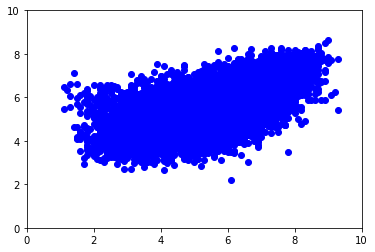

In [38]:
plt.scatter(y_test, y_predict3, color = 'b')
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.show()

In [41]:
import datetime
start = datetime.datetime.now()
regr2 = RandomForestRegressor(n_estimators=150, random_state = 42)
regr.fit(X_train, y_train)
y_predict4 = regr.predict(X_test)
print(r2_score(y_test, y_predict4))
end = datetime.datetime.now()
print(start, end)

0.44038770614893497
2021-09-06 13:34:56.160567 2021-09-06 13:45:53.734697


**<font color = 'teal'> Note: From above, it can be concluded that the Random Forest Regressor model performance is better than Linear Regresson model.**

# Gradient boosting 

In [42]:
def opt_gradientboosting(learning_rate, n_estimator, max_features, max_depth):
    for rate in learning_rate:
        gb = GradientBoostingRegressor(learning_rate = rate, n_estimators = n_estimator,  max_features = max_features, max_depth = max_depth)
        gb.fit(X_train, y_train)
        y_gb_predict = gb.predict(X_test)
        score_1 = r2_score(y_test, y_gb_predict)
        print(rate)
        print(score_1)
    return print('End')

In [43]:
learning_rate = [0.1, 1, 10]
start = datetime.datetime.now()
opt_gradientboosting(learning_rate, 10, 1027, 3)
end = datetime.datetime.now()
print(start, end)

0.1
0.26661488650130916
1
0.38716055959870743
10
-2.380036098546006e+18
End
2021-09-06 14:30:47.513626 2021-09-06 14:31:41.846209


In [44]:
opt_gradientboosting(learning_rate, 20, 1027, 3)

0.1
0.3441193034946183
1
0.4192110927519688
10
-2.8426996251467216e+37
End


In [46]:
learning_rate = [0.1, 1]
opt_gradientboosting(learning_rate, 50, 1027, 3)

0.1
0.405487314843786
1
0.430363709839758
End


In [47]:
opt_gradientboosting(learning_rate, 75, 1027, 3)

0.1
0.4220354538708946
1
0.44287293896783
End


In [48]:
opt_gradientboosting(learning_rate, 100, 1027, 3)

0.1
0.4306406063985203
1
0.4499986579437475
End


In [49]:
start = datetime.datetime.now()
opt_gradientboosting(learning_rate, 200, 1027, 3)
end = datetime.datetime.now()
print(start, end)

0.1
0.4512881418387964
1
0.4527696843476695
End
2021-09-06 14:53:48.441762 2021-09-06 15:05:17.090728


In [50]:
start = datetime.datetime.now()
learning_rate = [0.1, 1]
opt_gradientboosting(learning_rate, 300, 1027, 3)
end = datetime.datetime.now()
print(start, end)

0.1
0.4613471944989056
1
0.4543756585618456
End
2021-09-06 15:13:59.297184 2021-09-06 15:31:26.960782


start = datetime.datetime.now()
learning_rate = [0.1, 1]
opt_gradientboosting(learning_rate, 400, 1027, 3)
end = datetime.datetime.now()
print(start, end)

In [53]:
start = datetime.datetime.now()
learning_rate = [0.1, 1]
opt_gradientboosting(learning_rate, 500, 1027, 3)
end = datetime.datetime.now()
print(start, end)

0.1
0.47423013558800275
1
0.43158176629618317
End
2021-09-06 16:01:36.502660 2021-09-06 16:30:31.317804


**<font color='teal'> With learning_rate = 1, the r2_score has stated decreasing. Hence only learning_rate = 0.1 was only kept for further model building.** 

In [57]:
start = datetime.datetime.now()
learning_rate = [0.1]
opt_gradientboosting(learning_rate, 600, 1027, 3)
end = datetime.datetime.now()
print(start, end)

0.1
0.4769977595041094
End
2021-09-06 16:58:54.688942 2021-09-06 17:16:53.440884


In [58]:
start = datetime.datetime.now()
opt_gradientboosting(learning_rate, 700, 1027, 3)
end = datetime.datetime.now()
print(start, end)

0.1
0.4796443785326261
End
2021-09-06 17:35:17.229284 2021-09-06 17:59:41.322687


### With best n_estimator = 700, increase the max_depth from 3 to 5

In [59]:
start = datetime.datetime.now()
opt_gradientboosting(learning_rate, 700, 1027, 5)
end = datetime.datetime.now()
print(start, end)

0.1
0.49736629144537836
End
2021-09-06 18:06:04.419571 2021-09-06 18:22:26.440966


In [60]:
start = datetime.datetime.now()
opt_gradientboosting(learning_rate, 700, 1027, 7)
end = datetime.datetime.now()
print(start, end)

0.1
0.5055125785324059
End
2021-09-06 18:30:01.482743 2021-09-06 18:55:31.624772


### Got best n_estimator = 700, max_depth = 7

In [61]:
start = datetime.datetime.now()
learning_rate = [0.1]
opt_gradientboosting(learning_rate, 700, 1027, 10)
end = datetime.datetime.now()
print(start, end)

0.1
0.50426148134792
End
2021-09-06 19:15:59.209525 2021-09-06 20:21:57.988447


**<font color = 'teal'> Note: The performance decreased with increase in max_depth from 7 to 10.** 

In [62]:
#Let us decrease the features number and see the performance
start = datetime.datetime.now()
learning_rate = [0.1]
opt_gradientboosting(learning_rate, 700, 900, 7)
end = datetime.datetime.now()
print(start, end)

0.1
0.5040681217106112
End
2021-09-06 22:11:14.857542 2021-09-06 23:02:21.195565


In [63]:
# Let us decrease the features number and see the performance
start = datetime.datetime.now()
learning_rate = [0.1]
opt_gradientboosting(learning_rate, 700, 500, 7)
end = datetime.datetime.now()
print(start, end)

0.1
0.5048352956416153
End
2021-09-06 23:13:59.330348 2021-09-06 23:31:38.418384


In [64]:
start = datetime.datetime.now()
learning_rate = [0.1]
opt_gradientboosting(learning_rate, 700, 400, 7)
end = datetime.datetime.now()
print(start, end)

0.1
0.507286908005887
End
2021-09-06 23:58:59.503800 2021-09-07 00:07:07.683528


In [65]:
start = datetime.datetime.now()
learning_rate = [0.1]
opt_gradientboosting(learning_rate, 700, 300, 7)
end = datetime.datetime.now()
print(start, end)

0.1
0.5071950830068808
End
2021-09-07 00:09:38.200982 2021-09-07 00:21:14.019333


In [66]:
start = datetime.datetime.now()
learning_rate = [0.1]
opt_gradientboosting(learning_rate, 700, 200, 7)
end = datetime.datetime.now()
print(start, end)

0.1
0.5059793970267614
End
2021-09-07 00:27:56.265184 2021-09-07 00:38:40.548594


In [67]:
start = datetime.datetime.now()
learning_rate = [0.1]
opt_gradientboosting(learning_rate, 700, 100, 7)
end = datetime.datetime.now()
print(start, end)

0.1
0.5042961247293202
End
2021-09-07 00:40:23.764514 2021-09-07 00:46:08.133291


#### Note: Among all models, Gradient boosting with learning_rate = 0.1, n_estimator = 700, max_features = 300, Max_depth = 7 is with highest r2_score value:0.507. Hence this model will be saved for further use.

In [69]:
gb6 = GradientBoostingRegressor(learning_rate = 0.1, n_estimators = 700,  max_features = 300, max_depth = 7)

**<font color = 'teal'>To improve the models performanace, PCA was applied. Though it improved the Linear Regression model performance but it didn't help Random Forest Regeressor or Gradient Boosting Regressor. The PCA application and model optimization has been discussed in model Development Part-II and III**. <br><br>Both have been uploaed in Github in the following links:<br>https://github.com/damayantinaik/Springboard_Week_7_Capstone_Project_Netfilx/blob/main/Netflix_data_model_development_Part_II.ipynb <br> and <br> https://github.com/damayantinaik/Springboard_Week_7_Capstone_Project_Netfilx/blob/main/Netflix_data_model_development_PCAall_Part_III.ipynb

# Save the best model parameter for further use

In [71]:
best_model = gb6
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.X_columns = [col for col in X_train.columns]

In [73]:
# save the best model to disk
import os
import pickle
pickle.dump(best_model, open('Best_model.pkl', 'wb'))